# I TRUNCATED THE DATA IN THE DATALOADING SECTION

In [ ]:
import json
import torch
from torch import nn

from sklearn.model_selection import train_test_split
import time

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda


In [ ]:
# Hyperparameters / Variability management
DATALOADING_DATA_PATH = "/insert_file_path/all_tunes_cleaned_removed_whitespace.txt"
DATALOADING_VOCAB_PATH = "/insert_file_path/char_to_idx_truncated.json"

DATASET_SEQUENCE_LENGTH = 128
LOADER_BATCH_SIZE = 126

MODEL_EMBEDDING_DIM = 128 # Dimension of the embedding
MODEL_HIDDEN_SIZE = 128 # LSTM layer size
MODEL_LSTM_LAYERS = 1 # Number of LSTM layers
MODEL_SAVE_PATH =   '/insert_file_path/Dropout_model.pt'

TRAINING_EPOCHS = 15

RESULTS_LOAD_PATH =  '/insert_file_path/Dropout_model.pt'


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataloading

In [ ]:
with open(DATALOADING_DATA_PATH, "r") as f:
  data = f.read()

with open(DATALOADING_VOCAB_PATH) as f:
    char_to_index = json.load(f)
    index_to_char = {index: char for char, index in char_to_index.items()} # To transfer back

Translate the data to indices:

In [ ]:
data_translated = [char_to_index[char] for char in data]
data_translated = data_translated[:len(data_translated) // 250] # Truncate data
print("RAW FORMAT")
print(data[:10])

print("\nTRANSLATED FORMAT")
print(data_translated[:10])

print("LENGTH OF DATA:")
print(len(data_translated))

RAW FORMAT
X:1
L:1/8


TRANSLATED FORMAT
[89, 1, 29, 5, 71, 1, 29, 3, 50, 5]
LENGTH OF DATA:
186334


# Defining the data set class

In [ ]:
# Define the data set
# WARNING: TAKES TRANSLATED DATA FORMAT
class MusicDataset(torch.utils.data.Dataset):
    def __init__(self,
                 X, # The data in TRANSLATED FORMAT
                 sequence_len=1, # How much context does the model have?
                 ):

        self.X=torch.tensor(X, dtype=torch.long)
        self.sequence_len=sequence_len

    def __len__(self):
      # Make room for a last sequence and its target, hence the 1 also
        return len(self.X) - self.sequence_len - 1


    def __getitem__(self,idx):
        X = self.X[idx:idx+self.sequence_len] # 1 x sequence_len
        Ytarget = self.X[idx+self.sequence_len] # 1 x 1
        return X, Ytarget.long() # For dimensions to match LSTM layer :)

See [pyTorch LSTM layer](https://pytorch.org/docs/stable/generated/torch.nn.LSTM.html) for dimension details

In [ ]:
dataset = MusicDataset(X=data_translated, sequence_len=DATASET_SEQUENCE_LENGTH)

In [ ]:
# Unit tests:
train_idx, test_idx = train_test_split(range(len(dataset)), test_size=.1, shuffle=False)
train_dataset = torch.utils.data.Subset(dataset, train_idx)
test_dataset = torch.utils.data.Subset(dataset, test_idx)

x, y = train_dataset[1]

print("--- DIMENSIONS ---")
print("X:", x.shape)
print("y:", y.shape)


print("\n--- INPUT X ---")
print("RAW - First 10")
print(x[:10])


print("TRANSLATED")
print(*list(index_to_char[index.item()] for index in x), sep="")

print("\n--- TARGET Y ---")
print("RAW")
print(y)

print("TRANSLATED")
print(index_to_char[y.item()])

--- DIMENSIONS ---
X: torch.Size([128])
y: torch.Size([])

--- INPUT X ---
RAW - First 10
tensor([ 1, 29,  5, 71,  1, 29,  3, 50,  5,  0])
TRANSLATED
:1
L:1/8
M:4/4
K:Emin
|:E2EFE2EF|DEFGAFDF|E2EFE2B2|1efe^de2e2:|2efe^de3B|:e2efg2fe|
defgafdf|1e2efg2fe|efe^de3B:|2g2bgf2af|efe^d

--- TARGET Y ---
RAW
tensor(14)
TRANSLATED
e


Data is split up into 80% training, 20% test.

# Defining the pyTorch LSTM model

In [ ]:
class SimpleModel(nn.Module):
    def __init__(self,
                 embedding_dim, # Number of features - we have 1 because music!
                 hidden_size, # Hidden size of LSTM layer
                 num_layers, # Number of LSTM layers
                 ):

        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(char_to_index),
                                      embedding_dim=embedding_dim)

        self.LSTM = nn.LSTM(input_size=embedding_dim,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True)

        self.fc1 = nn.Linear(hidden_size,
                             hidden_size)

        self.fc2 = nn.Linear(hidden_size, len(char_to_index)) # hidden size x vocab size

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.LSTM(x) # Needs N x seq_L x FEATURE_DIM
        x = h_n[-1]
        x = self.fc1(x) # See w8_forecast solution for an explanation of slicing
        x = nn.functional.relu(x)
        x = self.fc2(x)
        return x

# Define data loaders

In [ ]:
batch_size = LOADER_BATCH_SIZE


train_loader = torch.utils.data.DataLoader(train_dataset,
                                           batch_size=batch_size,
                                           shuffle=True)
test_loader = torch.utils.data.DataLoader(test_dataset,
                                          batch_size=batch_size,
                                          shuffle=False)

# Training & testing the model

First setup:

In [ ]:
n_epochs = TRAINING_EPOCHS

model = SimpleModel(embedding_dim=MODEL_EMBEDDING_DIM,
                    hidden_size=MODEL_HIDDEN_SIZE,
                    num_layers=MODEL_LSTM_LAYERS
                    ).to(device)

loss_fn = nn.CrossEntropyLoss() # Because character classification task
optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

In [ ]:
# Sanity check loss function
for x_batch, y_batch in train_loader:
  x_batch, y_batch = x_batch.to(device), y_batch.to(device)
  break

print("X batch dim:", x_batch.shape)
print("y batch dim:", y_batch.shape)


model_output = model(x_batch)
print("y_pred dim:", model_output.shape)

loss_fn(model_output, y_batch)

X batch dim: torch.Size([126, 128])
y batch dim: torch.Size([126])
y_pred dim: torch.Size([126, 95])


tensor(4.5530, device='cuda:0', grad_fn=<NllLossBackward0>)

Training & Testing

In [ ]:
# TEST EVAL RUN
model.eval()
test_loss = 0
test_accuracy = 0

with torch.no_grad():
    for batch_number, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()

        test_accuracy += (y_pred.argmax(dim=1) == y_batch).sum().item()

        if batch_number % 1000 == 0:
          print(f"Batch {batch_number + 1}/{len(test_loader)}")

print(f"Accuracy {test_accuracy / len(test_dataset) * 100:.4f}%")
print(f"Initial loss: {test_loss / len(test_dataset):.4f}")

Batch 1/148
Accuracy 0.9774%
Initial loss: 0.0362


In [ ]:
train_loss = []
test_loss = []
train_accuracy = []
test_accuracy = []

def train(model, optimizer, loss_fn, train_loader):
    model.train()
    correct_predictions = 0
    total_samples = 0
    losses = 0

    for batch_number, (x_batch, y_batch) in enumerate(train_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()

        # Clip gradients (only if necessary)
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1)

        optimizer.step()

        losses += loss.item()
        correct_predictions += (y_pred.argmax(dim=1) == y_batch).sum().item()
        total_samples += y_batch.size(0)

        if batch_number % 1000 == 0:
            print(f"Batch {batch_number + 1}/{len(train_loader)}")

    train_loss.append(losses / len(train_loader))
    train_accuracy.append(correct_predictions / total_samples)
    print(f"Train Loss: {train_loss[-1]:.4f}, Train Accuracy: {train_accuracy[-1] * 100:.2f}%")


def test(model, loss_fn, test_loader):
    model.eval()
    correct_predictions = 0
    total_samples = 0
    losses = 0

    with torch.no_grad():
        for batch_number, (x_batch, y_batch) in enumerate(test_loader):
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            y_pred = model(x_batch)

            loss = loss_fn(y_pred, y_batch)

            losses += loss.item()
            correct_predictions += (y_pred.argmax(dim=1) == y_batch).sum().item()
            total_samples += y_batch.size(0)

            if batch_number % 1000 == 0:
                print(f"Batch {batch_number + 1}/{len(test_loader)}")

    test_loss.append(losses / len(test_loader))
    test_accuracy.append(correct_predictions / total_samples)
    print(f"Test Loss: {test_loss[-1]:.4f}, Test Accuracy: {test_accuracy[-1] * 100:.2f}%")

In [ ]:
# patience = 2
# best_loss = float('inf')
# epochs_without_improvement = 0

model_hidden_size_list = [128, 256]
lstm_layers_list = [2, 4]

model_dict = dict()

for model_hidden_size, lstm_layers in zip(model_hidden_size_list, lstm_layers_list):
    print(f"Model hidden size: {model_hidden_size}, LSTM layers: {lstm_layers}")
    model = SimpleModel(embedding_dim=MODEL_EMBEDDING_DIM,
                    hidden_size=model_hidden_size,
                    num_layers=lstm_layers
                    ).to(device)

    loss_fn = nn.CrossEntropyLoss() # Because character classification task
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    model_results = {
        'train_loss': [],
        'test_loss': [],
        'train_accuracy': [],
        'test_accuracy': []
    }

    # Training loop
    for epoch in range(n_epochs):
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{n_epochs}")

        # Train and test the model
        train(model, optimizer, loss_fn, train_loader)
        test(model, loss_fn, test_loader)

        # Save metrics for this epoch
        model_results['train_loss'].append(train_loss[-1])
        model_results['test_loss'].append(test_loss[-1])
        model_results['train_accuracy'].append(train_accuracy[-1])
        model_results['test_accuracy'].append(test_accuracy[-1])
        print(model_results)

    # Store the results for this model configuration in the dictionary
    model_dict[(model_hidden_size, lstm_layers)] = model_results



# for epoch in range(n_epochs):
#   if epoch % 1 == 0:
#     print(f"Epoch {epoch}/{n_epochs}")
#   train(model, optimizer, loss_fn, train_loader)
#   test(model, loss_fn, test_loader)



  # if test_loss[-1] < best_loss:
  #   best_loss = test_loss[-1]
  #   epochs_without_improvement = 0

  # else:
  #   epochs_without_improvement += 1
  # if epochs_without_improvement >= patience:
  #   print("Early stopping triggered.")
  #   break



Model hidden size: 128, LSTM layers: 2
Epoch 0/15
Batch 1/1331
Batch 1001/1331
Train Loss: 2.3646, Train Accuracy: 30.99%
Batch 1/148
Test Loss: 2.0267, Test Accuracy: 39.19%
{'train_loss': [2.364609059402586], 'test_loss': [2.026732949791728], 'train_accuracy': [0.3098684838648081], 'test_accuracy': [0.3919230975780033]}
Epoch 1/15
Batch 1/1331
Batch 1001/1331
Train Loss: 1.8284, Train Accuracy: 43.40%
Batch 1/148
Test Loss: 1.8830, Test Accuracy: 43.61%
{'train_loss': [2.364609059402586, 1.828377565524347], 'test_loss': [2.026732949791728, 1.8830098284257424], 'train_accuracy': [0.3098684838648081, 0.43395550887912926], 'test_accuracy': [0.3919230975780033, 0.43612050910262606]}
Epoch 2/15
Batch 1/1331
Batch 1001/1331
Train Loss: 1.6827, Train Accuracy: 47.37%
Batch 1/148
Test Loss: 1.8262, Test Accuracy: 45.49%
{'train_loss': [2.364609059402586, 1.828377565524347, 1.6827393859781599], 'test_loss': [2.026732949791728, 1.8830098284257424, 1.8262356028363511], 'train_accuracy': [0.3098

In [ ]:
import pickle

with open('/insert_file_path/normal_lstm_plots_dict.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

In [ ]:
save_path =  '/insert_file_path/big_model_lstm_save.pt'

In [ ]:
torch.save(model.state_dict(), save_path)

# Results

In [ ]:
load_path = RESULTS_LOAD_PATH
model = SimpleModel(embedding_dim=MODEL_EMBEDDING_DIM,
                    hidden_size=MODEL_HIDDEN_SIZE,
                    num_layers=MODEL_LSTM_LAYERS
                    ).to(device)
model.load_state_dict(torch.load(load_path, weights_only=True))

<All keys matched successfully>

Let's test the accuracy of predicting the next character in the musical sequence.

In [ ]:
# TEST EVAL RUN
"""
model.eval()
test_loss = 0
test_accuracy = 0

with torch.no_grad():
    for batch_number, (x_batch, y_batch) in enumerate(test_loader):
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        y_pred = model(x_batch)

        loss = loss_fn(y_pred, y_batch)
        test_loss += loss.item()

        test_accuracy += (y_pred.argmax(dim=1) == y_batch).sum().item()

        if batch_number % 1000 == 0:
          print(f"Batch {batch_number + 1}/{len(test_loader)}")

print(f"Accuracy {test_accuracy / len(test_dataset) * 100:.4f}%")
print(f"Loss: {test_loss / len(test_dataset):.4f}")
"""

Batch 1/148
Accuracy 45.2661%
Loss: 0.0177


Let the model iteratively predict some characters, given a starting sequence.

In [ ]:
start_sequence = """
X:7
L:1/16
M:2/4
K:D
A2F2A2d2|d2c2edc2|A2ceg2c2|e2d2fed2|A2F2A2d2|d2c2edc2|A2ceg2c2|d2d2d2z2::
d2B2dcBz|A2defed2|cdezefgz|gffgfedz|d2B2dcBz|A2defed2|cdefgfgc|
"""

In [ ]:
#Here we take the predicted output and append it to the new input, so we have y_hat = x
num_chars_to_predict = 50

print("Start sequence length:", len(start_sequence))

# Convert the initial sequence to tensor indices
input_sequence = [char_to_index[char] for char in start_sequence]
input_sequence = input_sequence[:DATASET_SEQUENCE_LENGTH] # Cant expect the data set to understand more/less context than what it trained on
input_tensor = torch.tensor(input_sequence, dtype=torch.long, device=device).unsqueeze(0)

print("Input tensor dims:", input_tensor.shape)

model.eval()
model.to(device)
result = model(input_tensor)
print("Result dims:", result.shape) # Sample prediction
print("Prediction:", result.argmax().item())

do_argmax = False

predictions = []
for _ in range(num_chars_to_predict):
    with torch.no_grad():
        output = model(input_tensor)

        if do_argmax:
            next_char_index = output.argmax().item()
        else:
            # Apply softmax to get probabilities
            probabilities = torch.nn.functional.softmax(output, dim=-1)

            # Sample from the probability distribution
            next_char_index = torch.multinomial(probabilities.squeeze(0), num_samples=1).item()

        predictions.append(next_char_index)

        model_input = torch.cat((model_input[:, 1:], torch.tensor([[next_char_index]], dtype=torch.long, device=device)), dim=1)

final_result = "".join(index_to_char[index] for index in predictions)

print()
print("INITIAL SEQUENCE:")
print(start_sequence)

print()
print("ACTUAL GIVEN SEQUENCE (TRUNCATED):")
print(start_sequence[:DATASET_SEQUENCE_LENGTH])

print()
print("PREDICTED SEQUENCE:")
print(final_result)

print()
print("INPUT AND OUTPUT COMBINED:")
print(start_sequence + final_result)


In [ ]:
# We can also do it where we dont use the multinomial model for getting the y+1
# Convert the initial sequence to tensor indices
input_sequence = [char_to_index[char] for char in start_sequence]
input_sequence = input_sequence[:DATASET_SEQUENCE_LENGTH] # Cant expect the data set to understand more/less context than what it trained on
input_tensor = torch.tensor(input_sequence, dtype=torch.long, device=device).unsqueeze(0)

print("Input tensor dims:", input_tensor.shape)

model.eval()
model.to(device)
result = model(input_tensor)
print("Result dims:", result.shape) # Sample prediction
print("Prediction:", result.argmax().item())


def get_next_char(input_tensor, do_argmax = False):
  predictions = []
  for _ in range(num_chars_to_predict):
      with torch.no_grad():
          output = model(input_tensor)

          if do_argmax:
              next_char_index = output.argmax().item()
          else:
              # Apply softmax to get probabilities
              probabilities = torch.nn.functional.softmax(output, dim=-1)

              # Sample from the probability distribution
              next_char_index = torch.multinomial(probabilities.squeeze(0), num_samples=1).item()

          predictions.append(next_char_index)

          model_input = torch.cat((model_input[:, 1:], torch.tensor([[next_char_index]], dtype=torch.long, device=device)), dim=1)

  return "".join(index_to_char[index] for index in predictions)


final_result = get_next_char(input_tensor)

print()
print("INITIAL SEQUENCE:")
print(start_sequence)

print()
print("ACTUAL GIVEN SEQUENCE (TRUNCATED):")
print(start_sequence[:DATASET_SEQUENCE_LENGTH])

print()
print("PREDICTED SEQUENCE:")
print(final_result)

print()
print("INPUT AND OUTPUT COMBINED:")
print(start_sequence + final_result)

Often the sequence gets stuck in a loop, lets introduce randomness:

In [ ]:
"""
probabilities = torch.nn.functional.softmax(output, dim=-1)
next_char_index = torch.multinomial(probabilities, num_samples=1)
"""

## Plotting of the output of the model

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.title("Loss plot of train and test loss function")
plt.legend()
plt.show()

In [ ]:

plt.plot(range(len(train_accuracy)), train_accuracy, label='train')
plt.plot(range(len(test_accuracy)), test_accuracy, label='test')
plt.title("Loss plot of train and test accuracy")
plt.legend()
plt.show()



# Here we have the new LSTM model that have the dropout layer and the early stopping

In [ ]:
class DropAllTablesModel(nn.Module):
    def __init__(self,
                 embedding_dim, # Number of features - we have 1 because music!
                 hidden_size, # Hidden size of LSTM layer
                 num_layers, # Number of LSTM layers
                 dropout_prob = 0.5):

        super().__init__()
        self.embedding = nn.Embedding(num_embeddings=len(char_to_index),
                                      embedding_dim=embedding_dim)

        self.LSTM = nn.LSTM(input_size=embedding_dim,
                          hidden_size=hidden_size,
                          num_layers=num_layers,
                          batch_first=True,
                          dropout = dropout_prob)


        self.fc1 = nn.Linear(hidden_size,
                             hidden_size)

        self.dropout = nn.Dropout(p=dropout_prob)

        self.fc2 = nn.Linear(hidden_size, len(char_to_index)) # hidden size x vocab size

    def forward(self, x):
        x = self.embedding(x)
        _, (h_n, _) = self.LSTM(x) # Needs N x seq_L x FEATURE_DIM
        x = h_n[-1]
        x = self.fc1(x) # See w8_forecast solution for an explanation of slicing
        x = nn.functional.relu(x)
        x = self.dropout(x)
        x = self.fc2(x)
        return x

In [ ]:
n_epochs = TRAINING_EPOCHS

dropout_model = DropAllTablesModel(embedding_dim=MODEL_EMBEDDING_DIM,
                    hidden_size=MODEL_HIDDEN_SIZE,
                    num_layers=MODEL_LSTM_LAYERS
                    ).to(device)

loss_fn = nn.CrossEntropyLoss() # Because character classification task
optimizer = torch.optim.Adam(dropout_model.parameters(), lr=0.001, weight_decay=1e-5)

/usr/local/lib/python3.10/dist-packages/torch/nn/modules/rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


In [ ]:
# patience = 2
# best_loss = float('inf')
# epochs_without_improvement = 0

model_hidden_size_list = [128, 256]
lstm_layers_list = [2, 4]

model_dict_dropout = dict()

for model_hidden_size, lstm_layers in zip(model_hidden_size_list, lstm_layers_list):
    print(f"Model hidden size: {model_hidden_size}, LSTM layers: {lstm_layers}")
    model = DropAllTablesModel(embedding_dim=MODEL_EMBEDDING_DIM,
                    hidden_size=model_hidden_size,
                    num_layers=lstm_layers
                    ).to(device)

    loss_fn = nn.CrossEntropyLoss() # Because character classification task
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)

    model_results = {
        'train_loss': [],
        'test_loss': [],
        'train_accuracy': [],
        'test_accuracy': []
    }

    # Training loop
    for epoch in range(n_epochs):
        if epoch % 1 == 0:
            print(f"Epoch {epoch}/{n_epochs}")

        # Train and test the model
        train(model, optimizer, loss_fn, train_loader)
        test(model, loss_fn, test_loader)

        # Save metrics for this epoch
        model_results['train_loss'].append(train_loss[-1])
        model_results['test_loss'].append(test_loss[-1])
        model_results['train_accuracy'].append(train_accuracy[-1])
        model_results['test_accuracy'].append(test_accuracy[-1])
        print(model_results)

    # Store the results for this model configuration in the dictionary
    model_dict_dropout[(model_hidden_size, lstm_layers)] = model_results



# for epoch in range(n_epochs):
#   if epoch % 1 == 0:
#     print(f"Epoch {epoch}/{n_epochs}")
#   train(dropout_model, optimizer, loss_fn, train_loader)
#   test(dropout_model, loss_fn, test_loader)

#   if test_loss[-1] < best_loss:
#     best_loss = test_loss[-1]
#     epochs_without_improvement = 0

#   else:
#     epochs_without_improvement += 1
#   if epochs_without_improvement >= patience:
#     print("Early stopping triggered.")
#     break

Model hidden size: 128, LSTM layers: 2
Epoch 0/15
Batch 1/1331
Batch 1001/1331
Train Loss: 2.5767, Train Accuracy: 26.25%
Batch 1/148
Test Loss: 2.1140, Test Accuracy: 37.18%
{'train_loss': [2.576736160277604], 'test_loss': [2.113987763185759], 'train_accuracy': [0.2624534561772007], 'test_accuracy': [0.37183824714032543]}
Epoch 1/15
Batch 1/1331
Batch 1001/1331
Train Loss: 2.0606, Train Accuracy: 37.30%
Batch 1/148
Test Loss: 1.9432, Test Accuracy: 40.14%
{'train_loss': [2.576736160277604, 2.0606357689462684], 'test_loss': [2.113987763185759, 1.9431504808567666], 'train_accuracy': [0.2624534561772007, 0.37295326522818406], 'test_accuracy': [0.37183824714032543, 0.40137479190161646]}
Epoch 2/15
Batch 1/1331
Batch 1001/1331
Train Loss: 1.9395, Train Accuracy: 39.88%
Batch 1/148
Test Loss: 1.8710, Test Accuracy: 41.92%
{'train_loss': [2.576736160277604, 2.0606357689462684, 1.9394570446659263], 'test_loss': [2.113987763185759, 1.9431504808567666, 1.871044934601397], 'train_accuracy': [0.2

In [ ]:
with open('/insert_file_path/dropout_model_lstm_plots_dict.pkl', 'wb') as file:
    pickle.dump(model_dict, file)

In [ ]:
save_path =  '/insert_file_path/big_model_lstm_with_dropout_save.pt'
torch.save(model.state_dict(), save_path)


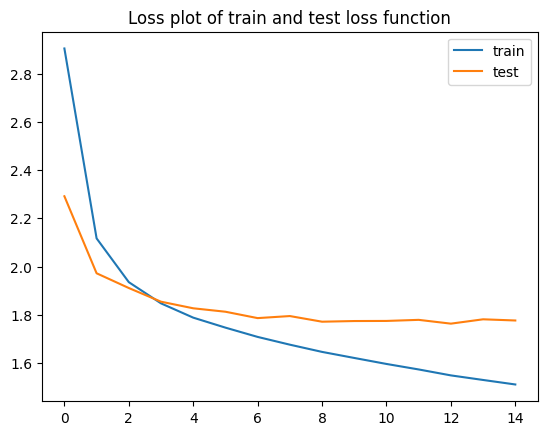

In [ ]:
import matplotlib.pyplot as plt

plt.plot(range(len(train_loss)), train_loss, label='train')
plt.plot(range(len(test_loss)), test_loss, label='test')
plt.title("Loss plot of train and test loss function")
plt.legend()
plt.show()

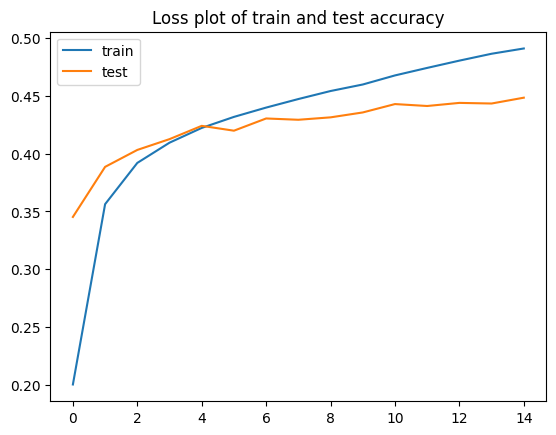

In [ ]:
plt.plot(range(len(train_accuracy)), train_accuracy, label='train')
plt.plot(range(len(test_accuracy)), test_accuracy, label='test')
plt.title("Loss plot of train and test accuracy")
plt.legend()
plt.show()
